## Visualization of Predicted vs. Actual Bandgap Values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Model selection
from sklearn.model_selection import train_test_split

# metrics for regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Final estimators
import lightgbm as lgb

### Load all datasets

In [2]:
start = time.time()

# Original data without any features
data0 = pd.read_excel('Bandgap_chain4209.xlsx')
data0 = data0.sort_values(by=["bandgap_chain"], ascending=True, ignore_index=True)

# Datasets with features
data1 = pd.read_csv('Bandgap_avalon_256rfe.csv')
data1 = data1.sort_values(by=["bandgap_chain"], ascending=True, ignore_index=True)

data2 = pd.read_csv('Bandgap_avalonc_256rfe.csv')
data2 = data2.sort_values(by=["bandgap_chain"], ascending=True, ignore_index=True)

data3 = pd.read_csv('Bandgap_layered_512rfe.csv')
data3 = data3.sort_values(by=["bandgap_chain"], ascending=True, ignore_index=True)

data4 = pd.read_csv('Bandgap_rdkitfp_512rfe.csv')
data4 = data4.sort_values(by=["bandgap_chain"], ascending=True, ignore_index=True)

stop = time.time()
runtime = stop - start

print(f"Runtime: {runtime} s")
print("All dataset imported.")

Runtime: 1.072507619857788 s
All dataset imported.


### Define functions

In [3]:
def train_weak_model(permutation, dataX, feature, size): ### start with training the weak models
    
    # dataX = dataset    
    # Level1 Holdout validation #####################################################
    training, testing = train_test_split(dataX, test_size=size, random_state=permutation)
    
    X_test = testing.iloc[:,2:].to_numpy()
    Y_test = testing['bandgap_chain'].to_numpy()
    
    X_train = training.iloc[:,2:].to_numpy()
    Y_train = training['bandgap_chain'].to_numpy()

    reg_ = lgb.LGBMRegressor()
    reg_.fit(X_train, Y_train)

    Y_train_pred = reg_.predict(X_train)
    Y_test_pred = reg_.predict(X_test)

    newtest = testing.iloc[:,:2].reset_index(drop=True)
    newtest[feature] = pd.Series(Y_test_pred)

    newtrain = training.iloc[:,:2].reset_index(drop=True)
    newtrain[feature] = pd.Series(Y_train_pred)

    newdata = pd.concat([newtrain, newtest], axis=0).reset_index(drop=True)
    newdata = newdata.sort_values(by=["bandgap_chain"], ascending=True, ignore_index=True)

    return newdata

In [4]:
def train_final_model(permutation, size): ### Training the final strong model

    # Get the weak models ###########################################
    newdata1 = train_weak_model(permutation, data1, 'Avalon_L', size)
    newdata2 = train_weak_model(permutation, data2, 'AvalonC_L', size)
    newdata3 = train_weak_model(permutation, data3, 'Layered_L', size)
    newdata4 = train_weak_model(permutation, data4, 'RDK_L', size)    
    
    
    newfinal = pd.concat([data0, newdata1.iloc[:,2],
                          newdata2.iloc[:,2],
                          newdata3.iloc[:,2],
                          newdata4.iloc[:,2],
                          ], axis=1).reset_index(drop=True)
    
    # Train the final models
        
    finaltrain, finaltest = train_test_split(newfinal, test_size=size, random_state=permutation)
    
    final_X_train = finaltrain.iloc[:,2:].to_numpy()
    final_X_train.reshape(final_X_train.shape[0], final_X_train.shape[1], 1) # need to reshape or else CNN error
    final_Y_train = finaltrain['bandgap_chain'].to_numpy()
    
    final_X_test = finaltest.iloc[:,2:].to_numpy()
    final_X_test.reshape(final_X_test.shape[0], final_X_test.shape[1], 1)
    final_Y_test = finaltest['bandgap_chain'].to_numpy()

    reg_ = lgb.LGBMRegressor()
    reg_.fit(final_X_train, final_Y_train)

    final_Y_train_pred = reg_.predict(final_X_train)

    final_Y_test_pred = reg_.predict(final_X_test)

    return final_Y_train, final_Y_train_pred, final_Y_test, final_Y_test_pred

### Extract the predicted and actual values

In [5]:
### LGB-stack 80/20
Y_train1, Y1a, _, _ = train_final_model(27, 0.2)
_, _, Y_test1, Y1b = train_final_model(7, 0.2)

### LGB-stack 90/10
Y_train2, Y2a, _, _ = train_final_model(27, 0.1)
_, _, Y_test2, Y2b = train_final_model(15, 0.1)

### LGB-stack 95/5
Y_train3, Y3a, _, _ = train_final_model(41, 0.05)
_, _, Y_test3, Y3b = train_final_model(47, 0.05)

### Plot with decorations

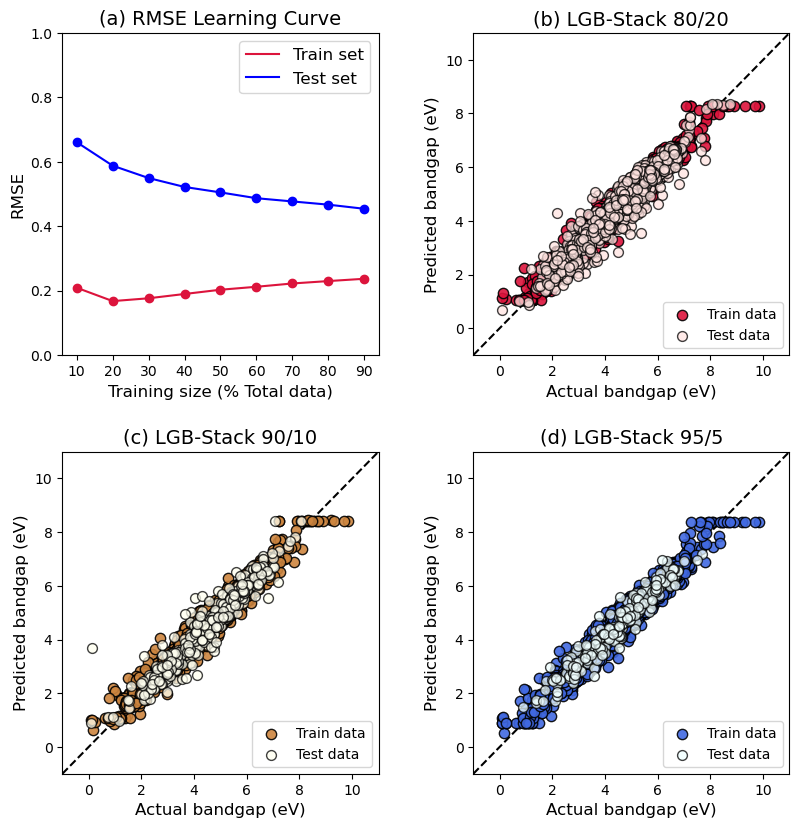

In [6]:
fig, axes = plt.subplots(2,2, figsize=(8,8), dpi=100)

fig.tight_layout()

# in the previous line, axes is a 1 x 2 array
# convert it into 1D array for easy indexing later.
axes = axes.flatten()

x_straight = np.linspace(-1, 11)
y_straight = x_straight

# plotting points on each subplot 

x1 = ['10', '20', '30', '40', '50', '60', '70', '80', '90']

# plotting points

y1a = [0.2088, 0.1674, 0.1762, 0.1895, 0.2027, 0.2119, 0.2221, 0.2296, 0.2367]
y1b = [0.6607, 0.5878, 0.5495, 0.5218, 0.5049, 0.4869, 0.4769, 0.4669, 0.4541]

axes[0].set_ylim([0, 1])

axes[0].scatter(x1, y1a, color='crimson')
axes[0].plot(x1, y1a, color='crimson', label='Train set') 

axes[0].scatter(x1, y1b, color='blue')
axes[0].plot(x1, y1b, color='blue', label='Test set')

axes[0].legend(loc='best', fontsize=12)
axes[0].set_title('(a) RMSE Learning Curve', fontsize=14)
axes[0].set_xlabel('Training size (% Total data)', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)

axes[1].set_xlim([-1,11])
axes[1].set_ylim([-1,11])
axes[1].plot(x_straight, y_straight, c='black', linestyle="--", zorder = 0)

axes[1].scatter(Y_train1, Y1a, s=55, c='crimson', label='Train data', 
            zorder = 10, edgecolors='black', alpha=0.9)
axes[1].scatter(Y_test1, Y1b, s=50, c='mistyrose', label='Test data', 
            zorder = 15, edgecolors='black', alpha=0.75)
axes[1].legend(loc=4)
axes[1].set_title('(b) LGB-Stack 80/20', fontsize=14)
axes[1].set_xlabel('Actual bandgap (eV)', fontsize=12)
axes[1].set_ylabel('Predicted bandgap (eV)', fontsize=12)

axes[2].set_xlim([-1,11])
axes[2].set_ylim([-1,11])
axes[2].plot(x_straight, y_straight, c='black', linestyle="--", zorder = 0)
axes[2].scatter(Y_train2, Y2a, s=55, c='peru', label='Train data', 
            zorder = 10, edgecolors='black', alpha=0.9)
axes[2].scatter(Y_test2, Y2b, s=50, c='ivory', label='Test data', 
            zorder = 15, edgecolors='black', alpha=0.75)
axes[2].legend(loc=4)
axes[2].set_title('(c) LGB-Stack 90/10', fontsize=14)
axes[2].set_xlabel('Actual bandgap (eV)', fontsize=12)
axes[2].set_ylabel('Predicted bandgap (eV)', fontsize=12)

axes[3].set_xlim([-1,11])
axes[3].set_ylim([-1,11])
axes[3].plot(x_straight, y_straight, c='black', linestyle="--", zorder = 0)
axes[3].scatter(Y_train3, Y3a, s=55, c='royalblue', label='Train data', 
            zorder = 10, edgecolors='black', alpha=0.9)
axes[3].scatter(Y_test3, Y3b, s=50, c='azure', label='Test data', 
            zorder = 15, edgecolors='black', alpha=0.75)
axes[3].legend(loc=4)
axes[3].set_title('(d) LGB-Stack 95/5', fontsize=14)
axes[3].set_xlabel('Actual bandgap (eV)', fontsize=12)
axes[3].set_ylabel('Predicted bandgap (eV)', fontsize=12)

# adjusting space between subplots 
fig.subplots_adjust(hspace=0.3, wspace=0.3) 
  
# function to show the plot 
plt.show()